# **Feature Selection Notebook**

## Objectives

* Answer business requirements 1
      - The client is interested in understanding the patterns from the heart disease database so that the client can learn the most relevant variables correlated to a positive heart desease prediction.

## Inputs

* outputs/datasets/collection/heart.csv

## Outputs

* Generate code that answer the first business requirement



---

# Set up the Working Directory

Define and confirm the working directory.

In [14]:
import os
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
current_dir

'/workspaces/heart-disease-analysis-and-prediction'

# Load data

In [16]:
df_raw_path = "outputs/datasets/collection/heart.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


---

# Explore the data

We are interested in getting more familiar with the data , so we generate ProfileReport to know the variable type , missing levels and distribution.

In [20]:
import pandas as pd
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the data we noticed that:
- All columns are numerical
- There are no missing values
- Few columns are inbalanced

---

# Correlation study

Initial Pearson and Spearman study.

In [21]:
corr_spearman = df.corr(method='spearman')['target'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman

cp         0.464894
ca        -0.453329
exang     -0.438029
oldpeak   -0.437669
thalach    0.429832
thal      -0.398973
slope      0.368808
sex       -0.279501
age       -0.240326
restecg    0.147402
Name: target, dtype: float64

In [24]:
corr_pearson = df.corr(method='pearson')['target'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

oldpeak    -0.438441
exang      -0.438029
cp          0.434854
thalach     0.422895
ca         -0.382085
slope       0.345512
thal       -0.337838
sex        -0.279501
age        -0.229324
trestbps   -0.138772
Name: target, dtype: float64

In [26]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'ca', 'cp', 'exang', 'oldpeak', 'thalach'}

After studying spearman and pearson correlation we found that the most correlate variables to target are the following:

- ca = -0.453329
- cp = 0.464894
- exang =  -0.438029
- oldpeak = -0.438441
- thalach = 0.429832

We do not have a strong correlation, where the max is ca and the min of the variables chosen is thalach. Developer will try to improve these correlation.

---

# Correlation matrix

Correlation matrix for spearman

In [31]:
spearman_correlation_matrix = df.corr(method='spearman')

In [34]:
pearson_correlation_matrix = df.corr(method='pearson')

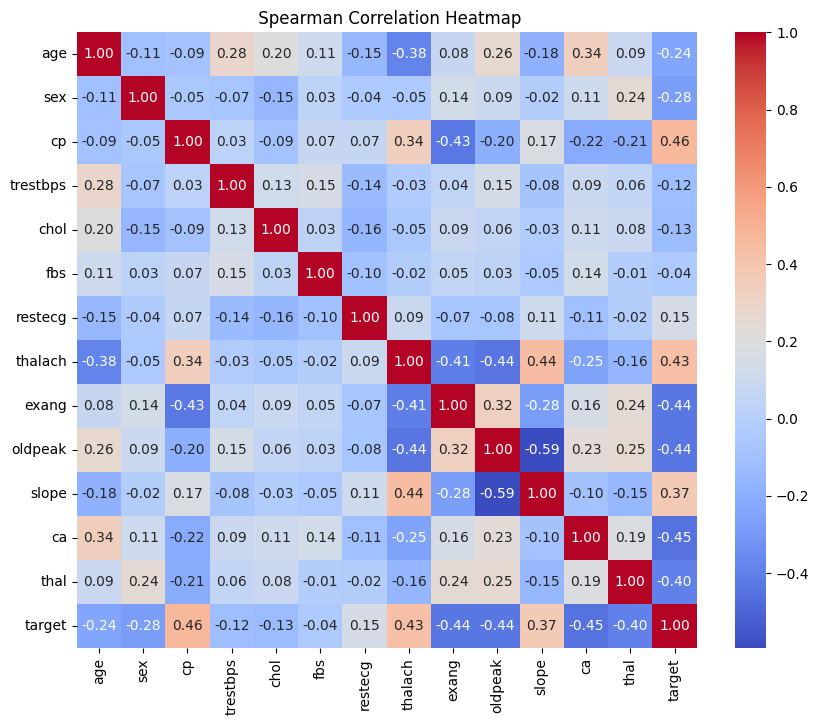

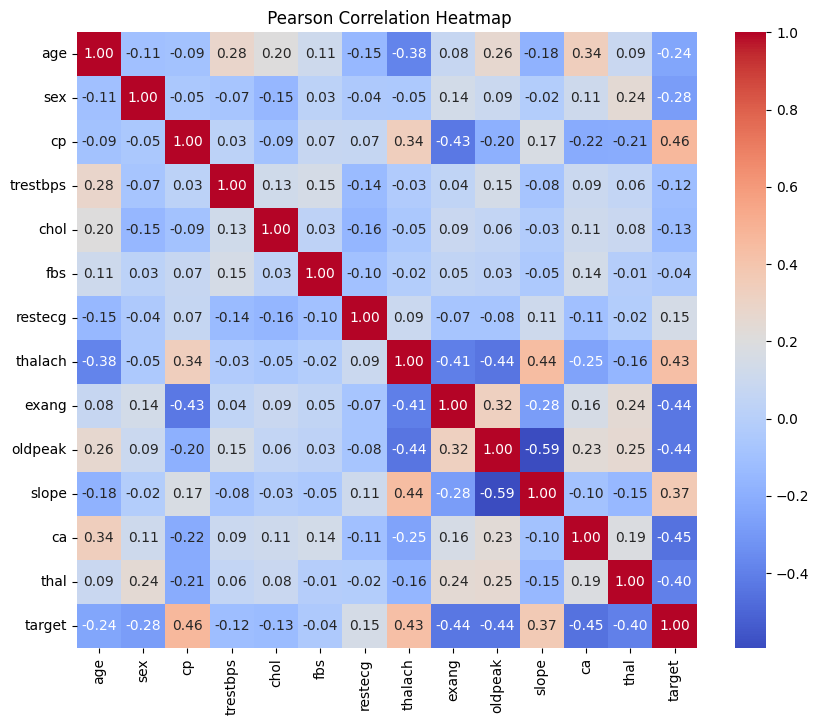

In [35]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(" Spearman Correlation Heatmap")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(" Pearson Correlation Heatmap")
plt.show()

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df,threshold, figsize=(20,12), font_annot = 8):
  if len(df.columns) > 1:
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                linewidth=0.5
                     )
    axes.set_yticklabels(df.columns, rotation = 0)
    plt.ylim(len(df.columns),0)
    plt.show()


def heatmap_pps(df,threshold, figsize=(20,12), font_annot = 8):
    if len(df.columns) > 1:

      mask = np.zeros_like(df, dtype=bool)
      mask[abs(df) < threshold] = True

      fig, ax = plt.subplots(figsize=figsize)
      ax = sns.heatmap(df, annot=True, xticklabels=True,yticklabels=True,
                       mask=mask,cmap='rocket_r', annot_kws={"size": font_annot},
                       linewidth=0.05,linecolor='grey')
      
      plt.ylim(len(df.columns),0)
      plt.show()

def CalculateCorrAndPPS(df):
  df_corr_spearman = df.corr(method="spearman")
  df_corr_pearson = df.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix,CorrThreshold,PPS_Threshold,
                      figsize=(20,12), font_annot=8 ):

  print("\n")
  print("* Analyze how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyze multi colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Predictive power Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
        f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df=pps_matrix,threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [51]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%    50%    75%    max
ppscore  182.0  0.065  0.104  0.0  0.0  0.007  0.092  0.509




* Analyze how the target variable for your ML models are correlated with other variables (features and target)
* Analyze multi colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



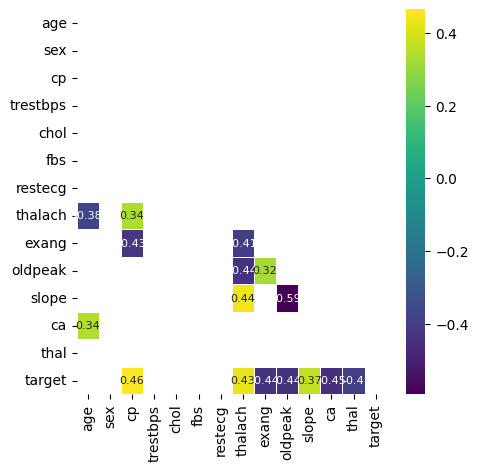



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



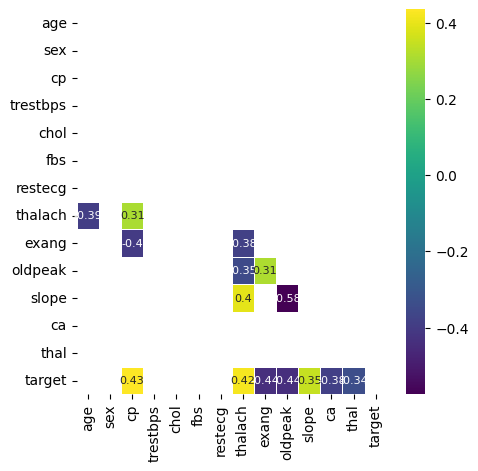



*** Heatmap: Predictive power Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



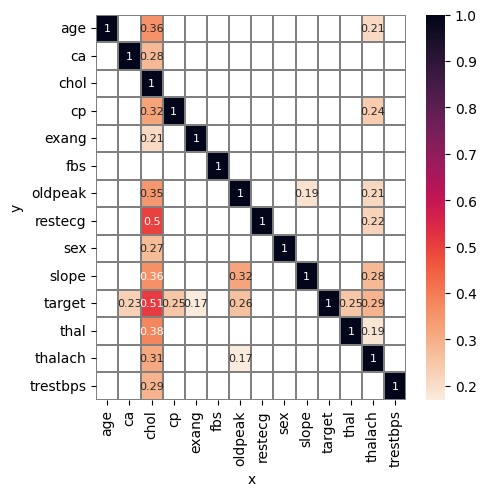

In [53]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.3, PPS_Threshold=0.15,
                  figsize=(5,5), font_annot=8)

# Conclusions

From this notebook we understood:
* Dataset is completely numerical
* After correlation analysis with pearson and spearman 5 important features where selected = **'ca', 'cp', 'exang', 'oldpeak', 'thalach'**
* After pps heatmap analysis developer will add another feature that could have an inportant predict power for the target: **'chol'** with a 0.51 predict power .
* In the next notebook there will be cleaning of the dataset.

First business requirement : As a business client I can analyze the variables, so that i understand which features are more related to heart disease.
First business requirement was answered finding the features that are more related to the target.
Future notebook will clean and save the dataset.

---